# Random Forest

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('/Users/uqhkamel/PhD/Code/AKI_mimiciv/mimic-code-main/mimic-iv/src')
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
import sqlite3

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score


from pickle import dump
from dfwiz import dfwiz

from sklearn.ensemble import RandomForestClassifier

from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import recall_score


# from sklearn.pipeline import Pipeline


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE



from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer

from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import resample

import copy

from sklearn import metrics


from utils.vis import spy, look, plot_nunique, plot_dists
from utils.processing import sort, impute, replace_inf, drop_empty, select, drop_by_nunique, scale, melt, unmelt, \
                             remove_outliers, get_categories, filter_categorical, onehot, filter_regex, match, cap,get_dates


In [3]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
pd.set_option("display.max_columns", None)

In [4]:
# global variables representing experiment parameters
EXPERIMENT = 'Processing Demo'
IMPUTE_NUM = 'constant'
IMPUTE_CAT = 'other'
FIGSIZE    = [12,3]

# parameter dict
params = {
    'experiment':EXPERIMENT,
    'figsize'   :FIGSIZE,
    'impute_num':IMPUTE_NUM,
    'impute_cat':IMPUTE_CAT,
}

In [5]:

import scipy as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn')
sns.set_theme(style="ticks")
mpl.rcParams['figure.figsize'] = (10,6)

# Title
mpl.rcParams['figure.titlesize'] = 22
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlepad'] = 20

# Axes labels
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelweight'] = 'bold'

# Grid and thicks
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'y'
#mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['ytick.left'] = False

# Legend
mpl.rcParams['legend.facecolor'] = 'w'
mpl.rcParams['legend.title_fontsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.facecolor'] = 'white'
mpl.rcParams['legend.edgecolor'] = 'blue'
mpl.rcParams['legend.borderpad'] = 0.6

# Other
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['scatter.edgecolors'] = None




_________
### upsampler func def

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

class upsampler(BaseEstimator, TransformerMixin): 
    def __init__(self):
        return None
    
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        return X

    def sample(self, X, y = None):
        X = np.array(X)
        y = np.array(y)
        if len(y[y == 0]) < len(y[y == 1]):
            X1, y1 = resample(X[y[y == 0]], y[y == 0], random_state=0, n_samples=len(y[y == 1]))
            X2, y2 = X[y[y == 1]], y[y == 1]
        else:
            print(X[y[y == 0]].shape)
            X1, y1 = resample(X[y[y == 1]], y[y == 1], random_state=0, n_samples=len(y[y == 0]))
            X2, y2 = X[y[y == 0]], y[y == 0]
        X_out = np.vstack((X1, X2))
        y_out = np.hstack((y1, y2))  

        return X_out, y_out


_________
### accuracy func def

In [7]:
def confusion_matrix_plot(y, y_pred, y_pred_proba):

    fpr, tpr, _ = metrics.roc_curve(y,   y_pred_proba[::,1])
    score = metrics.roc_auc_score(y,  y_pred_proba[::,1])

    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(round(score,2)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()


    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(7,7))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    
    accuracy = accuracy_score(y, y_pred)

    # print("Accuracy: %.2f%%" % (accuracy * 100.0))


    cr = classification_report(y, y_pred)
    print("\r\n"+"Classification report"+"\r\n")
    print(cr)

    print("\r\n_________________________________________")
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    specificity = tn / (tn+fp)
    print("\r\n"+"Specificity"+"\r\n")
    print(round(specificity,2))

    print("\r\n_________________________________________")



In [8]:
from sklearn.utils import resample

def up_sample(X_train_raw, y_train_raw,col_name):

    # upsampling X_train and y_train
    df_upsampled = pd.merge(X_train_raw, y_train_raw, left_index=True, right_index=True)

    X_minority = df_upsampled[df_upsampled[col_name]==1]
    X_majority = df_upsampled[df_upsampled[col_name]!=1]

    n_samples = X_majority.shape[0]
    X_minority_upsampled = resample(X_minority,
                                    replace=True,     # sample with replacement
                                    n_samples=n_samples,    # to match majority class
                                    random_state=42) # reproducible results

    df_upsampled = pd.concat([X_majority, X_minority_upsampled]).sample(frac=1)

    y_train_out = df_upsampled[[col_name]]
    X_train_out = df_upsampled.drop([col_name], axis=1)

    return X_train_out, y_train_out

_________
### define cross validation function

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold



def param_graph(X_train, y_train, pipe, param_grid, cv=5, max_iter = 5, sample_ratio = 0.2, refit=True, use_error=True, multi_class=False, average_metric='macro'):

    print("This search selects lower indexes of search list if their score is within the error of maximum score.")
    print("Putting parameters for less complicated model on the left side of the grid lists leads to better generalisation. ")
    print(" ")

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    n_train = int(sample_ratio * len(y_train))
    X_train_s, y_train_s  = resample(X_train, y_train, n_samples=n_train, stratify=y_train)

    best_score = {}
    best_params = {}
    for k, v in param_grid.items():
        # best_params[k] = v[int(len(v)/2)-1]
        best_params[k] = v[0]
    best_params_m1 = best_params.copy()
    print("start_params:", best_params)

    score = {}
    score_std = {}

    for i_iter in range(max_iter):
        print("_"*100)
        print("Iteration", i_iter)

        for k, v in param_grid.items():

            best_params1 = best_params.copy()
            del best_params1[k]  

            score[k] = v.copy()
            score_std[k] = v.copy()

            for i_param, val_param in enumerate(v):
                cv_sc = np.zeros(cv)

                for i_cv in range(cv):

                    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_s, y_train_s, test_size=0.2, stratify=y_train_s, shuffle=True) # 80% training and 20% test

                    p1 = copy.deepcopy(pipe)
                    p1.set_params(**best_params1)
                    params2 = {k:val_param}
                    p1.set_params(**params2)

                    p1.fit(X_train2, y_train2.ravel())
                    # X,y = p1.named_steps['resample'].fit_resample(X_test2, y_test2)
                    X,y = X_test2, y_test2
                    # y_pred_proba = p1.predict_proba(X)
                    # cv_sc[i_cv] = metrics.roc_auc_score(y,  y_pred_proba[::,1])
                    y_pred = p1.predict(X)
                    if(multi_class):
                        cv_sc[i_cv] = metrics.f1_score(y, y_pred, average=average_metric)
                    else:
                        cv_sc[i_cv] = metrics.f1_score(y, y_pred)

                    i_cv = i_cv + 1

                score[k][i_param] = cv_sc.mean()
                score_std[k][i_param] = cv_sc.std()

            print("")
            print(k)
            print(v)
            print(score[k])

            best_params[k] = v[np.argmax(score[k])]
            best_score[k] = score[k][np.argmax(score[k])]

            if use_error:
                for i_b in  range(np.argmax(score[k]),-1,-1):
                    err1 = (score_std[k][i_b] + score_std[k][v.index(best_params[k])] ) / 4
                    # print("err1")
                    max_del = max(score[k]) - err1
                    # print( i_b, score[k][i_b], max(score[k]), err1, max_del )
                    if score[k][i_b] >= max_del:
                        best_params[k] = v[i_b]
                        best_score[k] = score[k][i_b]

            print("best_param:",  v[np.argmax(score[k])], "score:", max(score[k]))
            print("selected_param:",  best_params[k], "score:", best_score[k])
            

        
        print("")
        print("best_params =", best_params)
        print("")
        if best_params_m1 == best_params:
            print("")
            print("")
            print("Early stop. No improvement in the last iteration.")
            break
        best_params_m1 = best_params.copy()

    param_graph_plot(score)

    if refit:
        print("Refitting final model...")
        model_final = copy.deepcopy(pipe)
        model_final.set_params(**best_params)
        model_final.fit(X_train, y_train.values.ravel())
    else:
        model_final = None

    return score, best_params, model_final
    

def param_graph_plot(score):
    ax = {}
    fig = {}
    for i, (k, v) in enumerate(score.items()):
        fig[k], ax[k] = plt.subplots()

    for k, v in score.items():
        x = score[k]
        y = v
        ax[k].plot(x,y,"-o", label="Score")
        # ax[k].set_ylim([0.5, 1])
        ax[k].set_title(k)
        ax[k].legend()

________
### Define upsampler

In [10]:

from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.utils import resample


class upsampler(BaseEstimator): 
    def __init__(self):
        return None

    def fit_resample(self, X, y = None):
        X = np.array(X)
        y = np.array(y).ravel()
        if len(y[y == 0]) < len(y[y == 1]):
            X1, y1 = resample(X[y == 0], y[y == 0], random_state=0, n_samples=len(y[y == 1]))
            X2, y2 = X[y == 1], y[y == 1]
        else:
            X1, y1 = resample(X[y == 1], y[y == 1], random_state=0, n_samples=len(y[y == 0]))
            X2, y2 = X[y == 0], y[y == 0]
        X_out = np.vstack((X1, X2))
        y_out = np.hstack((y1, y2))  
        return X_out, y_out

________
### Load data and select index

In [11]:
# get table from database
# database = "data.sqlite"
# con = sqlite3.connect(database)

# X_train = pd.read_sql_query("SELECT * from X_train", con)
# y_train = pd.read_sql_query("SELECT * from y_train", con)
# # select index
# index_c = ['USUBJID'] # empty list for no index
# X_train = X_train.set_index(index_c)
# y_train = y_train.set_index(index_c)

# X_train1 = X_train[~X_train.scr_umol_l.isna()]
# y_train1 = y_train[~X_train.scr_umol_l.isna()]

# X_test = pd.read_sql_query("SELECT * from X_test", con)
# y_test = pd.read_sql_query("SELECT * from y_test", con)
# # select index
# index_c = ['USUBJID'] # empty list for no index
# X_test = X_test.set_index(index_c)
# y_test = y_test.set_index(index_c)

# y_test = y_test[~X_test.scr_umol_l.isna()]
# X_test = X_test[~X_test.scr_umol_l.isna()]


# X_train, y_train  = resample(X_train, y_train, n_samples=5000, stratify=y_train)
# X_test, y_test  = resample(X_test, y_test, n_samples=1000, stratify=y_test)





In [12]:
# create a database connection
sqluser = 'uqhkamel'
dbname = 'mimiciv'
schema_name = 'mimic_derived'

In [13]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

In [14]:
query = "select * from all_scr_preadmission_75_JOIN"
data = pd.read_sql_query(query,con,index_col=['stay_id','subject_id'])
data.drop('hadm_id', inplace=True, axis=1)

In [15]:
data['ethnicity'] = data['ethnicity'].replace(['OTHER'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNKNOWN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['AMERICAN INDIAN/ALASKA NATIVE'],np.nan)

data = data.fillna(value=np.nan)


In [16]:
# aki_kdigo = ['aki_kdigo_grade_1','aki_kdigo_grade_2','aki_kdigo_grade_3']

# outcome_var = ['day_detection_kdigo_grade_1','day_detection_kdigo_grade_2','day_detection_kdigo_grade_3']

# outcome_var.append('min_day_rrt_present')


# first_24h = 1
# data= data[data[outcome_var].min(axis=1)>first_24h]

In [17]:
data.shape

(45349, 110)

In [18]:
outcome_var = []
outcome_var.append('min_day_rrt_present')


first_24h = 1
data= data[data[outcome_var].min(axis=1)>first_24h]

In [19]:
x1 = data.shape[0]

In [20]:
x1

44199

In [21]:
data.ckd.value_counts()

0    37058
1     7141
Name: ckd, dtype: int64

In [22]:
data = data[data['ckd']==0]

In [23]:
data.kidney_transplant.value_counts()


0    36939
1      119
Name: kidney_transplant, dtype: int64

In [24]:
data = data[data['kidney_transplant']==0]

In [25]:
76540 - 31191 - 1195 - 7141 - 119

36894

In [26]:
# data[data.egfr_mdrd_scr<60].shape

In [27]:
data_tmp = data.copy()

In [28]:
data.head(5)

,,aki_kdigo_grade_1,aki_kdigo_grade_2,aki_kdigo_grade_3,day_detection_kdigo_grade_1,day_detection_kdigo_grade_2,day_detection_kdigo_grade_3,aki_mkdigo_grade_1,aki_mkdigo_grade_2,aki_mkdigo_grade_3,day_detection_mkdigo_grade_1,day_detection_mkdigo_grade_2,day_detection_mkdigo_grade_3,age,female,ethnicity,ckd,is_mdrd,egfr_epi_scr,egfr_mdrd_scr,kidney_transplant,congestive_heart_failure,diabetes_type2,chronic_kidney_disease,hypertension,obesity_icd,peripheral_vascular_disease,chronic_liver_disease,mild_liver_disease,severe_liver_disease,myocardial_infarct,chronic_pulmonary_disease,chronic_heart_failure,sepsis,hematocrit_min,hematocrit_max,hemoglobin_min,hemoglobin_max,platelets_min,platelets_max,wbc_min,wbc_max,wbc_bd_min,wbc_bd_max,albumin_min,albumin_max,globulin_min,globulin_max,total_protein_min,total_protein_max,aniongap_min,aniongap_max,bicarbonate_min,bicarbonate_max,bun_min,bun_max,calcium_min,calcium_max,chloride_min,chloride_max,creatinine_min,creatinine_max,glucose_min,glucose_max,sodium_min,sodium_max,potassium_min,potassium_max,pt_min,pt_max,thrombin_min,thrombin_max,ptt_min,ptt_max,inr_min,inr_max,bilirubin_total_min,bilirubin_total_max,egfr_epi_scr_max,egfr_mdrd_scr_max,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,dbp_max,dbp_mean,resp_rate_min,resp_rate_max,resp_rate_mean,temperature_min,temperature_max,temperature_mean,spo2_min,spo2_max,arbs_acei,cyclosporine,bmi,urineoutput_24hr,supplemental_oxygen,invasive_vent,hfnc,non_invasive_vent,tracheostomy,min_day_rrt_present,min_day_rrt_active,weight_admit,weight_min,weight_max
stay_id,subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30000153,12466550,0,0,0,9999999.0,9999999.0,9999999.0,1,0,0,2.0,9999999.0,9999999.0,61.0,0,WHITE,0,1,72.0,68.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29.1,39.1,9.8,13.0,162.0,177.0,15.2,17.9,15.2,17.9,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,19.0,23.0,22.0,25.0,7.4,8.0,115.0,115.0,0.9,1.2,144.0,192.0,142.0,145.0,4.4,4.8,13.1,13.2,NaN,NaN,22.8,25.3,1.1,1.1,NaN,NaN,65.0,62.0,83.0,128.0,106.576923,108.0,169.0,134.857143,55.0,90.0,67.178571,10.0,22.0,15.000000,36.00,38.22,37.312500,92.0,100.0,0,0,NaN,280.0,1,1,0,0,0,99999999.0,99999999.0,70.0,70.0,73.0
30001148,12980335,1,0,0,2.0,9999999.0,9999999.0,1,0,0,1.0,9999999.0,9999999.0,68.0,0,NaN,0,1,73.0,71.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,25.2,32.3,8.5,11.0,160.0,198.0,7.4,11.7,7.4,11.7,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,25.0,27.0,9.0,12.0,NaN,NaN,108.0,111.0,0.6,0.6,119.0,119.0,138.0,138.0,4.2,4.7,13.6,14.9,NaN,NaN,27.3,29.5,1.2,1.3,NaN,NaN,103.0,134.0,64.0,80.0,75.520000,92.0,125.0,108.155172,48.0,76.0,58.620690,3.0,23.0,14.750000,35.33,38.17,36.390000,92.0,100.0,0,0,35.9,205.0,1,0,0,0,0,99999999.0,99999999.0,65.7,65.7,69.9
30001446,16513856,1,1,0,1.0,1.0,9999999.0,1,1,0,1.0,1.0,9999999.0,56.0,0,WHITE,0,0,25.0,25.0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,20.6,23.6,7.2,7.9,51.0,51.0,13.0,14.1,13.0,14.1,1.8,1.8,NaN,NaN,NaN,NaN,14.0,19.0,13.0,17.0,70.0,70.0,7.0,7.6,102.0,104.0,2.5,2.9,75.0,94.0,128.0,132.0,3.7,4.0,22.4,24.1,NaN,NaN,38.4,40.6,2.1,2.3,5.5,6.4,23.0,23.0,72.0,83.0,75.916667,75.0,111.0,98.090909,41.0,63.0,54.045455,14.0,28.0,20.333333,35.89,36.72,36.220000,90.0,100.0,0,0,NaN,40.0,0,0,0,0,0,99999999.0,99999999.0,119.3,119.3,119.3
30001656,19609454,0,0,0,9999999.0,9999999.0,9999999.0,1,1,0,1.0,9999999.0,9999999.0,68.0,1,WHITE,0,1,75.0,71.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32.9,37.9,12.4,13.6,245.0,304.0,10.8,14.5,10.8,14.5,3.8,3.8,NaN,NaN,NaN,NaN,9.0,16.0,26.0,26.0,13.0,18.0,7.7,7.7,97.0,99.0,0.5,0.6,83.0,103.0,128.0,137.0,3.5,3.7,11.7,11.7,NaN,NaN,20.1,20.1,1.0,1.0,0.6,0.6,94.0,99.0,69.0,102.0,82.148148,103.0,174.0,138.333333,58.0,107.0,72.000000,11.0,24.0,15.375000,36.33,37.50,36.928571,99.0,100.0,0,0,NaN,375.0,1,1,0,0,0,99999999.0,99999999.0,71.0,71.0,75.7
30001947,15904173,0,0,0,9999999.0,9999999.0,9999999.0,0,0,0,9999999.0,9999999.0,9999999.0,46.0,0,WHITE,0,0,96.0,85.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,21.7,28.6,6.9,8.7,161.0

In [29]:
# data.dropna(axis=1, thresh = int(0.8*data.shape[0]), inplace=True)

In [30]:
# pd.set_option('display.max_rows', None)

In [31]:
# data.isna().sum()/len(data)*100

In [32]:
# prediction_window = 3

# data.loc[(((data['aki_kdigo_grade_1']== 1)| (data['aki_kdigo_grade_2']== 1) | (data['aki_kdigo_grade_3']==1)) \
#     &( (data['day_detection_kdigo_grade_1']<=prediction_window)| (data['day_detection_kdigo_grade_2']<=prediction_window) | (data['day_detection_kdigo_grade_3']<=prediction_window)) \
#         |(data['min_day_rrt_present']<= prediction_window)), 'outcome'] = 1


# data.loc[data.outcome.isna(),'outcome']=0

In [33]:
data.shape

(36939, 110)

In [34]:
prediction_window = 3

data.loc[(( (data['aki_kdigo_grade_1']== 1)) \
    &( (data['day_detection_kdigo_grade_1']<=prediction_window))), 'outcome'] = 1


data.loc[data.outcome.isna(),'outcome']=0

In [35]:
drop_X   = [
'day_detection_kdigo_grade_1',
'day_detection_kdigo_grade_2',
'day_detection_kdigo_grade_3',
'day_detection_mkdigo_grade_1',
'day_detection_mkdigo_grade_2',
'day_detection_mkdigo_grade_3',
'min_day_rrt_active',
'min_day_rrt_present',
'ckd',
'chronic_kidney_disease'
]
# CRP and vomit_nausea as they had mostly empty

data.drop(drop_X, inplace=True, axis=1)

## Missingness percentage

In [36]:
# data.reset_index().drop_duplicates(subset=['stay_id','subject_id','hadm_id']).set_index(['stay_id','subject_id','hadm_id'])

In [37]:
# # remove unpopulated columns
# data.pipe(sort)\
#               .pipe(replace_inf).pipe(drop_empty)

In [38]:
data.shape

(36939, 101)

In [39]:
# split by column type
data_num = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'numerical')

data_cat = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'categorical')

In [40]:
data_num.shape

(36939, 94)

In [41]:
data_cat.shape

(36939, 1)

In [42]:
data_cat.head(20)

,,ethnicity
stay_id,subject_id,
30000153,12466550,WHITE
30001148,12980335,NaN
30001446,16513856,WHITE
30001656,19609454,WHITE
30001947,15904173,WHITE
30002415,17921898,WHITE
30002498,17938576,WHITE
30002548,14311522,WHITE
30002925,10208468,WHITE


In [43]:
# data_cat = data_cat.pipe(filter_categorical, cutoff=20, plot=False)\
#                                             .pipe(sort)\
#                                             .fillna('other').pipe(onehot)
data_cat = data_cat.fillna('other').pipe(onehot)

In [44]:
data_cat

len                                               \
variable            ethnicity                                                
value                   ASIAN BLACK/AFRICAN AMERICAN HISPANIC/LATINO WHITE   
stay_id  subject_id                                                          
30000153 12466550           0                      0               0     1   
30001148 12980335           0                      0               0     0   
30001446 16513856           0                      0               0     1   
30001656 19609454           0                      0               0     1   
30001947 15904173           0                      0               0     1   
...                       ...                    ...             ...   ...   
39999172 15669140           0                      0               0     1   
39999230 13651601           0                      0               0     1   
39999286 11305179           0                      0               0     1   
39999552 11256534           0                      0               0     1   
39999810 17840864           0                      0               0     1   

                           
variable                   
value               other  
stay_id  subject_id        
30000153 12466550       0  
30001148 12980335       1  
30001446 16513856       0  
30001656 19609454       0  
30001947 15904173       0  
...                   ...  
39999172 15669140       0  
39999230 13651601       0  
39999286 11305179       0  
39999552 11256534       0  
39999810 17840864       0  

[36939 rows x 5 columns]

In [45]:
processed = pd.merge(data_num, data_cat, left_index=True, right_index=True, how='inner')

In [46]:
processed.shape

(36939, 99)

In [47]:
processed.aki_kdigo_grade_3.value_counts()

0    35670
1     1269
Name: aki_kdigo_grade_3, dtype: int64

In [48]:
# processed.is_mdrd.value_counts()
processed['is_mdrd'].sum()/len(processed)*100

64.41701183031483

In [49]:
processed2 = processed.copy()
processed.drop(['egfr_epi_scr','egfr_mdrd_scr'], inplace=True, axis=1)

In [50]:
drop_X   = [
    'aki_kdigo_grade_1',
    'aki_mkdigo_grade_1',

    'aki_kdigo_grade_2',
    'aki_mkdigo_grade_2',

    'aki_kdigo_grade_3',
    'aki_mkdigo_grade_3',

    'is_mdrd'

]
 
select_y = ['outcome']

processed_X = processed.pipe(filter_regex, drop_X+select_y)
processed_Y = processed.filter(regex='|'.join(select_y))
raw_Y = data_num.pipe(replace_inf).pipe(drop_empty).filter(regex='|'.join(select_y)).pipe(remove_outliers)
df_y = raw_Y[select_y]


df_X, df_y = match(processed_X, df_y)

In [51]:
X, y = df_X, df_y

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [52]:
# X_train, y_train = df_X, df_y
X_train, y_train = up_sample(X_train, y_train,'outcome')

___________________
### Define pipeline

In [53]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline(steps=[
# ('resample', upsampler()),
('scaler', MinMaxScaler()),
('imputer',IterativeImputer(max_iter=10, random_state=42, missing_values=np.nan)),
('model', LogisticRegression(random_state=42, n_jobs=-1) )
])

___________________
### Cross validation search

In [54]:
########### **************************************8
# Make sure simpler models are at the start of array. The search picks numbers on the left side if they are within the error of maximum score.   


param_grid = {
    'model__penalty' : ['l1','l2']
}


# score, best_params, model_final = param_graph(X_train, y_train, pipe, param_grid, cv=5, max_iter = 4, sample_ratio = 0.1, refit=False, use_error=True)

# dump(model_final , open('model_final_LGBM.pkl', 'wb'))

__________
### Fitting Pipeline one time

/Users/uqhkamel/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(




______________________________________________________________________________________________________________________________________________________

Train Accuracy:



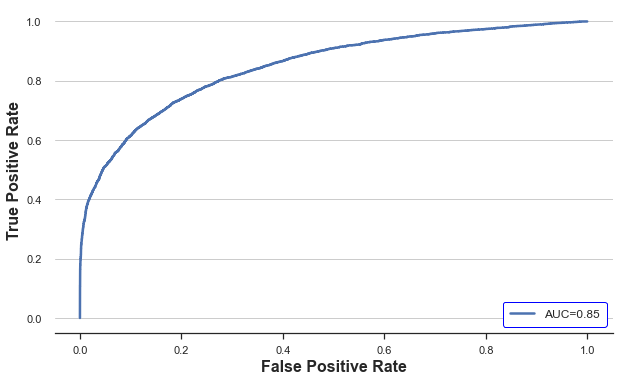

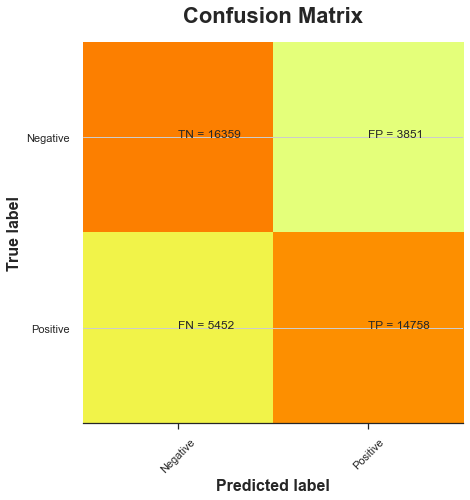


Classification report

              precision    recall  f1-score   support

         0.0       0.75      0.81      0.78     20210
         1.0       0.79      0.73      0.76     20210

    accuracy                           0.77     40420
   macro avg       0.77      0.77      0.77     40420
weighted avg       0.77      0.77      0.77     40420


_________________________________________

Specificity

0.81

_________________________________________


In [55]:
# manual params setting
best_params2 = {'model__penalty' : 'l2'}

# Or get parameters from search above
# best_params2 = best_params

sample_ratio = 1
n_samples = int(len(X_train)*sample_ratio)
X, y = resample(X_train.values, y_train.values, n_samples=n_samples, stratify=y_train.values, random_state=10)
model_final = copy.deepcopy(pipe)
model_final.set_params(**best_params2)
model_final.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = model_final.predict(X)
y_pred_proba = model_final.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)




# dump(model_final, open('pipe_rf.pkl', 'wb'))


__________
### Test accuracy

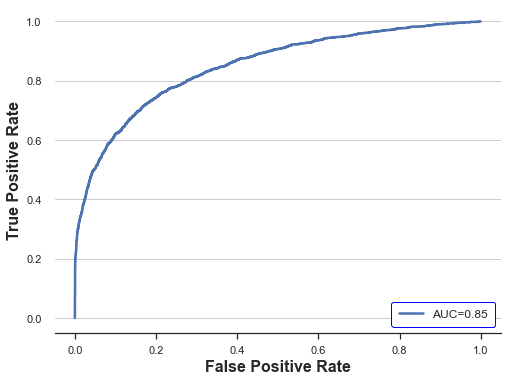

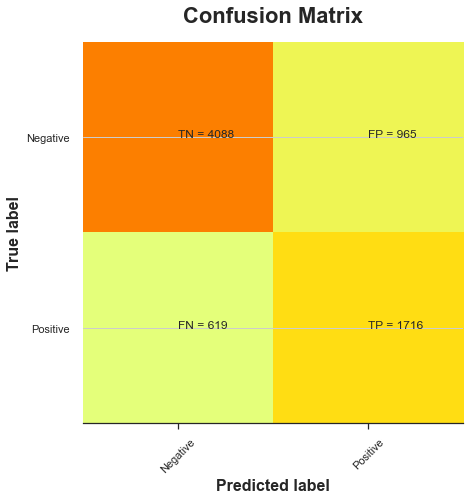


Classification report

              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84      5053
         1.0       0.64      0.73      0.68      2335

    accuracy                           0.79      7388
   macro avg       0.75      0.77      0.76      7388
weighted avg       0.80      0.79      0.79      7388


_________________________________________

Specificity

0.81

_________________________________________


In [56]:

# X,y = model_final.named_steps['resample'].fit_resample(X_test, y_test)
plt.rcParams["figure.figsize"] = (8,6)

X,y = X_test.values, y_test.values

y_pred = model_final.predict(X)
y_pred_proba = model_final.predict_proba(X)
y_pred  = (y_pred_proba[:,1] >= 0.5).astype(int)

confusion_matrix_plot(y, y_pred, y_pred_proba)


In [57]:
fpr_LR_grade123, tpr_LR_grade123, _ = metrics.roc_curve(y,   y_pred_proba[::,1])
%store fpr_LR_grade123
%store tpr_LR_grade123

Stored 'fpr_LR_grade123' (ndarray)
Stored 'tpr_LR_grade123' (ndarray)
